# Lab 04 - Machine learning with Spark MLlib


### Part 1

In [2]:
inputPath = '/data/students/bigdata_internet/lab4/log_tcp_complete_classes.txt'

In [3]:
in_DF=spark.read.load(inputPath,format='csv',sep=' ',header=True,inferSchema=True)

#### 1.1 - Number of columns/features

In [4]:
print(f"The number of features is {len(in_DF.columns)}")

The number of features is 207


#### 1.2 - Identify TCP connections

TCP connections are identified by the same IPs and port numbers

In [5]:
n_tcp_records = in_DF.count()
print(f"Number of TCP records in the file: {n_tcp_records}")

23/01/24 21:39:33 WARN util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


Number of TCP records in the file: 100000


### Part 2.0

#### 2.0.1 - Number of classes

The class is found in feature 207 and there are 10 distinct classes.

In [6]:
classes_DF = in_DF.select(in_DF.columns[206]).distinct()
n_classes = classes_DF.count()
print(f"Number of distinct classes: {n_classes}")

[Stage 5:=====================================>                 (136 + 2) / 200]

Number of distinct classes: 10


#### 2.0.2/3 - Listing all classes and counting the connections per web service

Each class has 10000 records

In [7]:
connPerWS_DF = in_DF.select(in_DF.columns[206])\
        .groupBy(in_DF.columns[206]).agg({in_DF.columns[206]:'count'})
connPerWS_DF.show()

+---------------+----------------+
|      class:207|count(class:207)|
+---------------+----------------+
|   class:google|           10000|
|   class:amazon|           10000|
|class:instagram|           10000|
| class:facebook|           10000|
|  class:netflix|           10000|
|     class:ebay|           10000|
|  class:spotify|           10000|
| class:linkedin|           10000|
|  class:youtube|           10000|
|     class:bing|           10000|
+---------------+----------------+



### Part 2.1 - Select features & perform preprocessing

Selected features: number of packets, payload bytes, n. of segments with payload, n. of bytes transmitted in the payload, n. of retransmitted packets, N. of retransmitted bytes, flow duration (ms), connection type, HTTP type, n. HTTP requests C2S, n. HTTP responses S2C, average RTT and maximum segment sizes

Add RTT info

In [8]:
## Print some rows to see values of column -- TEST
n_emp_116 = in_DF.select(in_DF.columns[115])\
        .withColumnRenamed(in_DF.columns[115], 'es').filter('es == "-"').count()
print(f"Empty rows - col. 116: {n_emp_116}")

n_emp_127 = in_DF.select(in_DF.columns[126])\
        .withColumnRenamed(in_DF.columns[126], 'es').filter('es == "-"').count()
print(f"Empty rows - col. 127: {n_emp_127}")

Empty rows - col. 116: 43112
Empty rows - col. 127: 3770


In [9]:
# Select correct features
index_total_feat = [2, 6, 7, 8, 9, 10,16, 20, 21, 22, 23, 24,\
                   30, 41, 43, 45, 52, 70, 93, 110, 111, 206]
featuresList = [in_DF.columns[n] for n in index_total_feat]
fullDS_DF = in_DF.select(featuresList)

#### 2.1.1/.2 - IP and ports as features & Using Fully Qualified Domain Name

It does not make sense to use the IP addresses and port numbers as features since the same client (ip) can request different websites and usually same protocols correspond to the same port numbers.

The FQDN is retrieved by Tstat from DNHunter, which essentially reads the DNS record associated to the server IP. The main problem is that in many cases the FQDN cannot be retrieved, therefore column 127 contains a lot of empty records (shown above). Additionally, a feature this specific will easily overfit on the training data.


### Part 2.2 - Separate training and test set

In [10]:
## Create training and test set (tr.: 75%, te.: 25%)
tr_DF, te_DF = fullDS_DF.randomSplit([0.75, 0.25], seed=10)
print(f"Number of elements in the training set: {tr_DF.count()}\
        \nNumber of elements in the test set {te_DF.count()}")

Number of elements in the training set: 75252        
Number of elements in the test set 24748


### Part 2.3 - Pre-processing

In [11]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
## String indexers
col_to_be_changed = [in_DF.columns[41], in_DF.columns[43], in_DF.columns[206]]
new_col_names = ['con_t_val', 'http_t_val', 'label']
Indexers = [
    StringIndexer(inputCol=col_to_be_changed[ind], outputCol=new_col_names[ind]) \
            for ind in range(len(col_to_be_changed))]

In [12]:
### Vector Assembler to group regressing features
regressingFeaturesList = featuresList.copy()
# Remove the class to get regressing features
del regressingFeaturesList[-1]
for i, x in enumerate(regressingFeaturesList):
    for ind in range(len(col_to_be_changed)):
        if x == col_to_be_changed[ind]:
            regressingFeaturesList[i] = new_col_names[ind]
VA = VectorAssembler(inputCols=regressingFeaturesList, outputCol='features')

In [13]:
## Normalization - SCALER
Scaler = StandardScaler(inputCol="features", outputCol="features_norm", withStd=True, withMean=False)

In [14]:
from pyspark.ml import Pipeline
## Assembling preprocessing pipeline.
preproc_pipeline = Pipeline(stages=Indexers+[VA, Scaler])
fitted_preproc_pipeline = preproc_pipeline.fit(tr_DF)
preproc_tr_DF = fitted_preproc_pipeline.transform(tr_DF)
preproc_te_DF = fitted_preproc_pipeline.transform(te_DF)

### Part 2.4 - Classification models

In this case, the used models are a random forest classifier and a decision tree classifier.
For both, the training time was measured. Then the models were tested on the training set.

#### 1 - Using Random Forest Classifier

20 trees, depth = 30

In [44]:
from pyspark.ml.classification import RandomForestClassifier
RFC = RandomForestClassifier(labelCol='label', featuresCol='features_norm', 
                seed=10, numTrees=20, maxDepth=30)

In [45]:
# Train the model and apply it
# In this case, we also measure the time it takes for training
import time
start_RFC = time.time()
fitted_RFC = RFC.fit(preproc_tr_DF)
end_RFC = time.time()
time_train_RFC = end_RFC - start_RFC
print(f"Training time for Random Forest Classifier: {round(time_train_RFC, 2)} seconds")

Training time for Random Forest Classifier: 74.71 seconds


In [46]:
RFC_validation_DF = fitted_RFC.transform(preproc_tr_DF)

#### 2 - Using decision tree classifier

Parameters:

* `maxDepth`: 20

In [18]:
from pyspark.ml.classification import DecisionTreeClassifier
DTC = DecisionTreeClassifier(labelCol='label', featuresCol='features', maxDepth = 20)

In [19]:
start_DTC = time.time()
fitted_DTC = DTC.fit(preproc_tr_DF)
end_DTC = time.time()
time_train_DTC = end_DTC - start_DTC
print(f"Time to train Decision Tree Classifier: {round(time_train_DTC, 2)} seconds")

Time to train Decision Tree Classifier: 7.41 seconds


In [20]:
DTC_validation_DF = fitted_DTC.transform(preproc_tr_DF)

#### 2.4.1 - Training times:

The training times can be seen as outputs of the previous cells.

### Part 2.5 - Performance evaluation over training set

The considered figures of merit are: accuracy, confusion matrix and precision.

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### 1 - Random Forest Classifier performance:

##### Accuracy

In [47]:
acc_eval = MulticlassClassificationEvaluator(
            predictionCol='prediction', 
            labelCol='label', 
            metricName='accuracy')

acc_RFC = acc_eval.evaluate(RFC_validation_DF)
print(f"Accuracy via Random Forest Classifier: {acc_RFC}")

[Stage 4211:>                                                       (0 + 2) / 2]

Accuracy via Random Forest Classifier: 0.9881138941273341


##### Confusion matrix

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

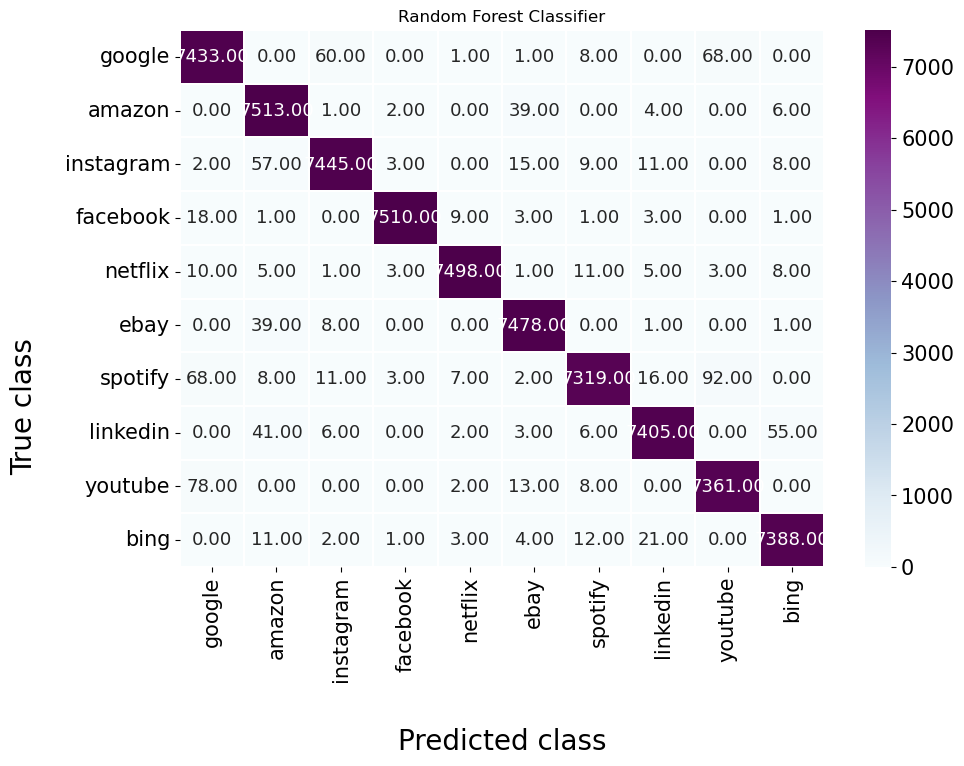

In [25]:
#### Confusion Matrix
# `printConfMatrix(DF, title)` is the function provided for 
# plotting the confusion matrix

printConfMatrix(RFC_validation_DF, "Random Forest Classifier")

##### Precision

#### 2 - Decision Tree Classifier

##### Accuracy

In [26]:
acc_DTC = acc_eval.evaluate(DTC_validation_DF)
print(f"Accuracy via Decision Tree Classifier: {acc_DTC}")

[Stage 156:==========================================>              (3 + 1) / 4]

Accuracy via Decision Tree Classifier: 0.968973175694546


##### Confusion matrix

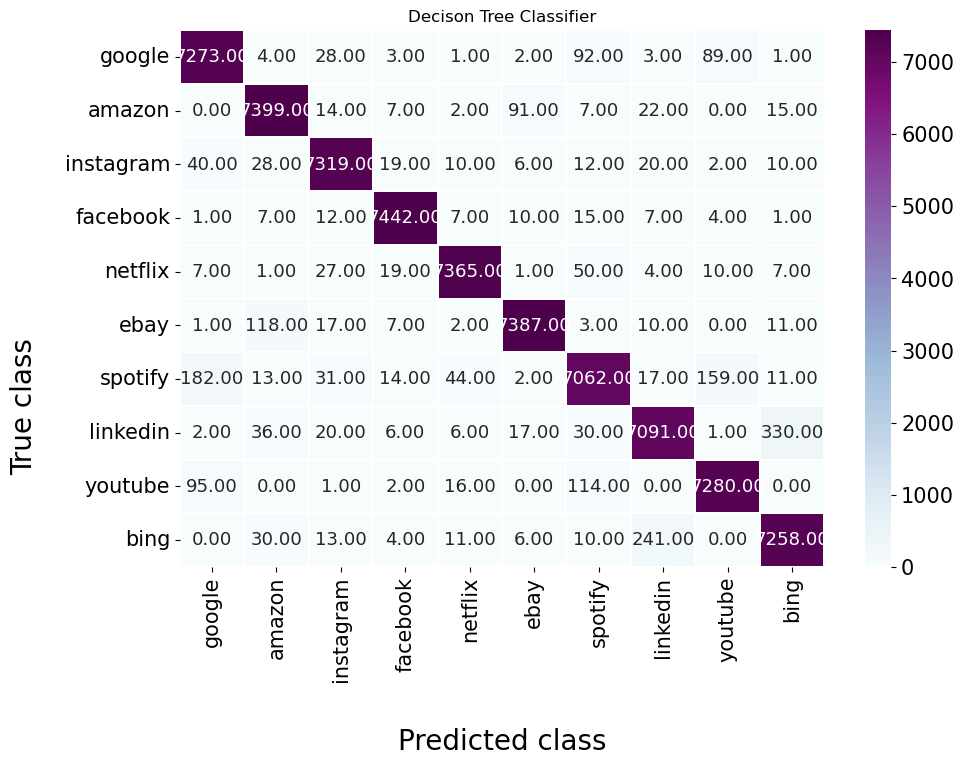

In [27]:
# Confusion Matrix
printConfMatrix(DTC_validation_DF, "Decison Tree Classifier")

##### Precision

#### 2.5.1 - Comments on the results

The obtained result denote a good capacity of both classifier to determine the websites, having accuracies above 96%.
As expected the preformance of the decision tree classifier is lower than the random forest, as the presence of one single tree makes the classifier less able to correctly learn different patterns in the training data.

#### 2.5.2 - Best classifier

The random forest classifier seems to be the best one considering both classification performance and training time.
Also the Neural Network was tried, however the results were very bad (28% accuracy), even after a training time of 1 hour and it was therefore removed.

### Part 2.6 - Tuning the model parameters

#### 1 - Random Forest Classifier

Acting on: number of trees, tree depth.


In [49]:
RFC_opt = RandomForestClassifier(labelCol = 'label', featuresCol = 'features_norm', seed=10, impurity='Entropy')

In [50]:
from pyspark.ml.tuning import ParamGridBuilder
grid_RFC = ParamGridBuilder()\
            .addGrid(RFC_opt.maxDepth, [15, 20, 25, 30])\
            .addGrid(RFC_opt.numTrees, [5, 10, 15, 20])\
            .build()

In [51]:
from pyspark.ml.tuning import CrossValidator
cv_RFC = CrossValidator(estimator=RFC_opt, evaluator=acc_eval, \
                        estimatorParamMaps=grid_RFC, numFolds=3, \
                        parallelism=3)

In [52]:
cv_RFC_fitted = cv_RFC.fit(preproc_tr_DF)
### Output was removed because it contained very long logs

In [53]:
RFC_cross_valid = cv_RFC_fitted.transform(preproc_tr_DF)

In [54]:
import pandas as pd
res_RFC = pd.DataFrame.from_dict([
    {cv_RFC_fitted.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(grid_RFC, cv_RFC_fitted.avgMetrics)
])
res_RFC.columns = ['accuracy', 'maxDepth', 'numTrees']
print(res_RFC)

    accuracy  maxDepth  numTrees
0   0.937057        15         5
1   0.944318        15        10
2   0.946036        15        15
3   0.948617        15        20
4   0.948294        20         5
5   0.956289        20        10
6   0.959679        20        15
7   0.961342        20        20
8   0.950142        25         5
9   0.957898        25        10
10  0.961422        25        15
11  0.962845        25        20
12  0.950422        30         5
13  0.958085        30        10
14  0.961635        30        15
15  0.963031        30        20


In [55]:
## Max (averaged) accuracy achieved:
cv_RFC_fitted.avgMetrics[np.argmax(cv_RFC_fitted.avgMetrics)]

0.9630308427981349

In [56]:
import numpy as np

# Get the parameters associated with the best classifier (max accuracy)
RFC_params = cv_RFC_fitted\
        .getEstimatorParamMaps()[np.argmax(cv_RFC_fitted.avgMetrics)]

#### 2 - Decision Tree Classifier

Tune `treeDepth` and `impurity`

In [36]:
DTC_opt = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features_norm')

In [37]:
grid_DTC = ParamGridBuilder()\
            .addGrid(DTC_opt.maxDepth, [15, 20, 25, 30])\
            .addGrid(DTC_opt.impurity, ['Gini', 'Entropy'])\
            .build()

In [38]:
cv_DTC = CrossValidator(estimator=DTC_opt, evaluator=acc_eval,\
                        estimatorParamMaps=grid_DTC, numFolds=3, \
                        parallelism=3)

In [39]:
cv_DTC_fitted = cv_DTC.fit(preproc_tr_DF)

In [40]:
res_DTC = pd.DataFrame.from_dict([
    {cv_DTC_fitted.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(grid_DTC, cv_DTC_fitted.avgMetrics)
])
res_DTC.columns = ['accuracy', 'maxDepth', 'impurity']
print(res_DTC)

   accuracy  maxDepth impurity
0  0.898446        15     Gini
1  0.899081        15  Entropy
2  0.903543        20     Gini
3  0.907298        20  Entropy
4  0.902608        25     Gini
5  0.907471        25  Entropy
6  0.902421        30     Gini
7  0.907458        30  Entropy


In [41]:
DTC_params = cv_DTC_fitted\
        .getEstimatorParamMaps()[np.argmax(cv_DTC_fitted.avgMetrics)]

#### 2.6.1 - Comments

The accuracies obtained during cross-validation remarked the previous results, which depict an overall better performance for the random forest classifier. It is to point out that different runs of the cross validation yield different results (due to the random nature of the classifiers).

### Part 2.7 - Test the best model on the test dataset


In [57]:
# Get best model:
RFC_best = cv_RFC_fitted.bestModel
RFC_tested_best_DF = RFC_best.transform(preproc_te_DF)

In [58]:
## Evaluate performance
acc_te_best_RFC = acc_eval.evaluate(RFC_tested_best_DF)
print(f"Accuracy on the test set via optimal Random Forest Classifier: {acc_te_best_RFC}") 

[Stage 6872:=============================================>        (21 + 4) / 25]

Accuracy on the test set via optimal Random Forest Classifier: 0.9758022515123593


#### 2.7.1 - Comments on best model

The best model is the random forest classifier using  with maximum depth = 30 and 20 trees.
The achieved accuracy on the test set was 97.58%, which is comparable with the maximum value reported when performing parameter tuning (around 96%).